The Iris cubes used in this notebook are publicly available in the [``SciTools/iris-sample-data``](https://github.com/SciTools/iris-sample-data) repository.

In [1]:
import datetime
import iris
import numpy as np
import holoviews as hv
import geoviews as gv
from cartopy import crs
from cartopy import feature as cf
hv.notebook_extension()

## Setting some notebook-wide options

Let's start by setting some normalization options (discussed below) and always enable colorbars for the elements we will be displaying:

In [2]:
iris.FUTURE.strict_grib_load = True
%opts Image {+framewise} [colorbar=True] {+framewise} Curve [xrotation=60]

Note that it is easy to set global defaults for a project, allowing any suitable settings to be made into a default on a per-element basis. Now let's specify the maximum number of frames we will be displaying:

In [3]:
%output max_frames=1000 


<div class="alert alert-info" role="alert">When working on a live server append ``widgets='live'`` to the line above for greatly improved performance and memory usage </div>


## Loading our first cube

Here is the summary of the first cube containing some surface temperature data:

In [4]:
iris_cube = iris.load_cube(iris.sample_data_path('GloSea4', 'ensemble_001.pp'))
iris_cube.coord('latitude').guess_bounds()
iris_cube.coord('longitude').guess_bounds()

In [5]:
print iris_cube.summary()

surface_temperature / (K)           (time: 6; latitude: 145; longitude: 192)
     Dimension coordinates:
          time                           x            -               -
          latitude                       -            x               -
          longitude                      -            -               x
     Auxiliary coordinates:
          forecast_period                x            -               -
     Scalar coordinates:
          forecast_reference_time: 2011-07-18 00:00:00
     Attributes:
          STASH: m01s00i024
          source: Data from Met Office Unified Model
          um_version: 7.6
     Cell methods:
          mean: time (1 hour)


Now we can wrap this Iris cube in a ``Dataset``:

In [6]:
surface_temperature = hv.Dataset(iris_cube)
surface_temperature

:Dataset   [time,longitude,latitude]   (surface_temperature)

# A Simple example

Here is a simple example of viewing the ``surface_temperature`` cube over time with a single line of code. In HoloViews, this datastructure is a ``HoloMap`` of ``Image`` elements:

:HoloMap   [time]
   :Image   [longitude,latitude]   (surface_temperature)
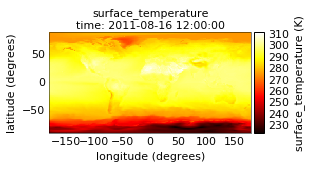
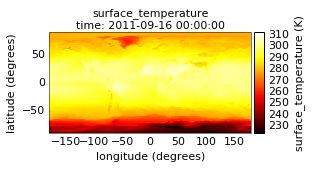
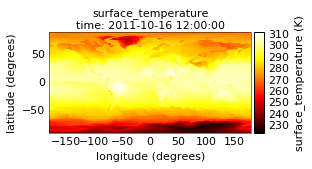
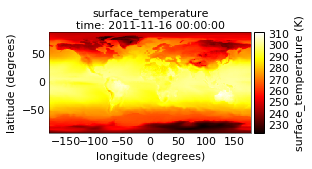
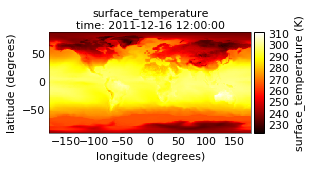
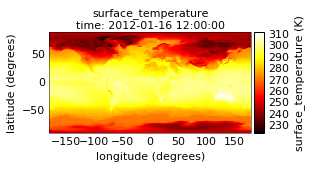

In [7]:
surface_temperature.to(gv.Image,['longitude', 'latitude'])

You can drag the slider to view the surface temperature at different times. Here is how you can view the values of time in the cube via the HoloViews API:

In [8]:
surface_temperature.dimension_values('time')

array([ 364860.,  364860.,  364860., ...,  368532.,  368532.,  368532.])

The times shown in the slider are long, making the text rather small. We can use the fact that all times are recorded in the year 2011 on the 16th of each month to shorten these dates. Defining how all dates should be formatted as follows will help with readability:

In [9]:
hv.Dimension.type_formatters[datetime.datetime] = "%m/%y %Hh"

Now let us load a cube showing the pre-industrial air temperature:

In [10]:
air_temperature = hv.Dataset(iris.load_cube(iris.sample_data_path('pre-industrial.pp')),
                             group='Pre-industrial air temperature')
air_temperature.data.coord('longitude').guess_bounds()
air_temperature.data.coord('latitude').guess_bounds()
air_temperature     # Use air_temperature.data.summary() to see the Iris summary (.data is the Iris cube)

:Dataset   [longitude,latitude]   (air_temperature)

Note that we have the ``air_temperature`` available over ``longitude`` and ``latitude`` but *not* the ``time`` dimensions. As a result, this cube is a single frame (at right below) when visualized as a temperature map.

:Layout
   .Surface_temperature.I                         :HoloMap   [time]
      :Image   [longitude,latitude]   (surface_temperature)
   .Pre_hyphen_minus_industrial_air_temperature.I :Image   [longitude,latitude]   (air_temperature)
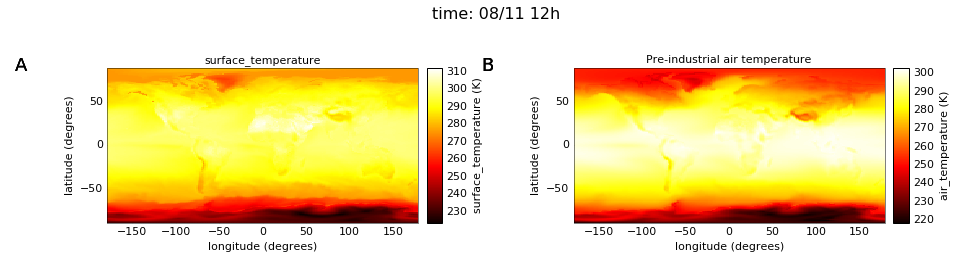
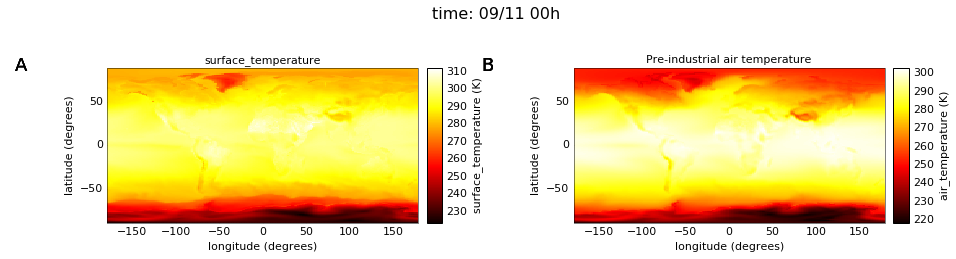
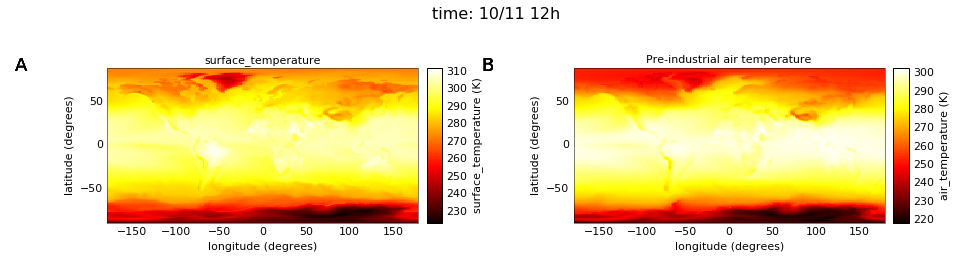
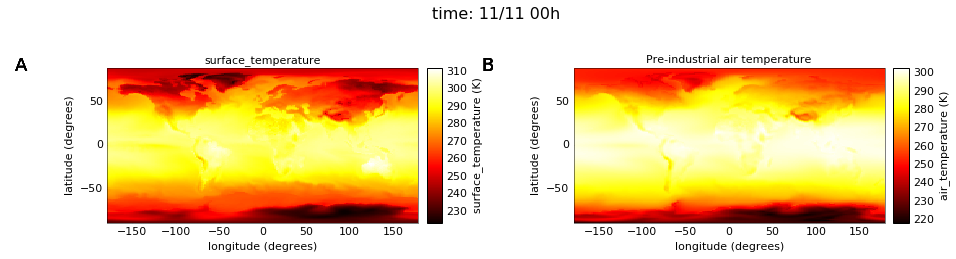
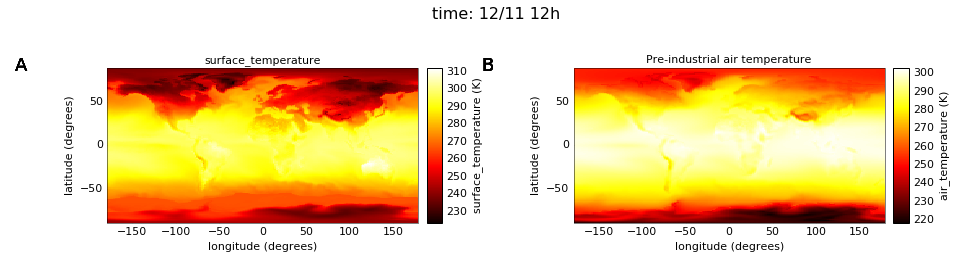
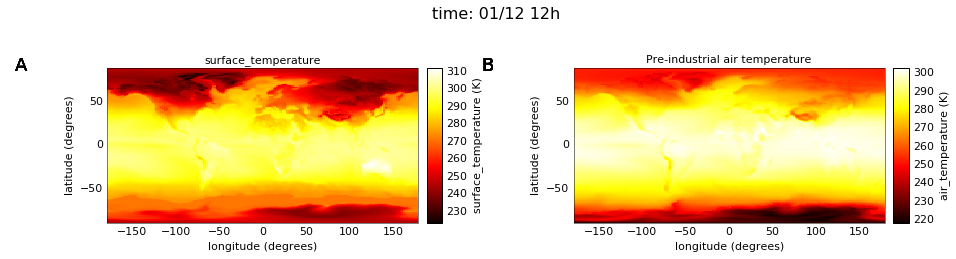

In [11]:
%%opts Layout [fig_inches=(12,4)]
(surface_temperature.to.image(['longitude', 'latitude'])+
 air_temperature.to.image(['longitude', 'latitude'])(plot=dict(projection=crs.PlateCarree())))

Next is a fairly involved example that plots an arbitrary number of HoloViews objects side by side in a ``Layout``, rather than using the fixed-layout ``+`` operator. 

This example shows how complex plots can be generated with little code, and also demonstrates how different HoloViews elements can be combined together. In the following visualization, the curve is a sample of the ``surface_temperature`` at longitude and latitude *(0,10)*, and it's unaffected by the slider because it already lays out time along the x axis:

:Layout
   .HoloMap.I             :HoloMap   [time]
      :Overlay
         .Surface_temperature.I :Image   [longitude,latitude]   (surface_temperature)
         .Points.I              :Points   [Longitude,Latitude]
   .Overlay.I             :Overlay
      .Pre_hyphen_minus_industrial_air_temperature.I :Image   [longitude,latitude]   (air_temperature)
      .Points.I                                      :Points   [Longitude,Latitude]
   .Surface_temperature.I :Curve   [time]   (surface_temperature)
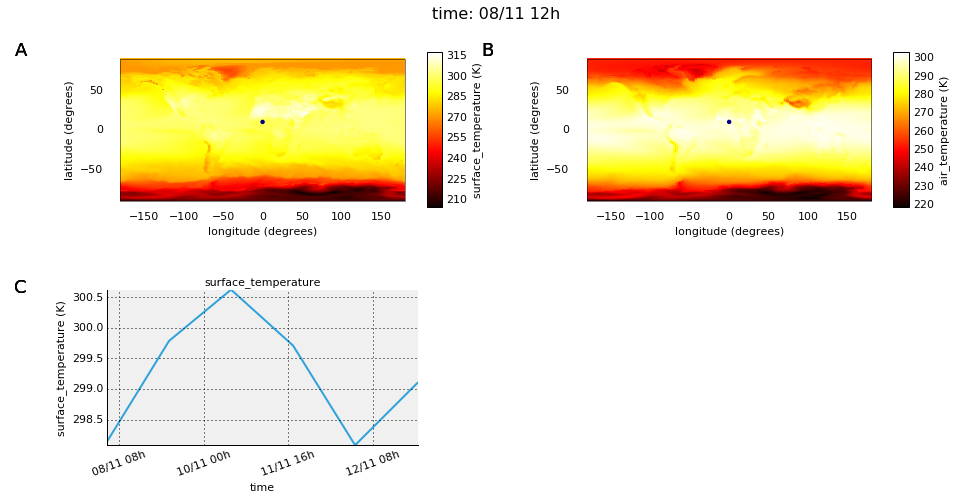
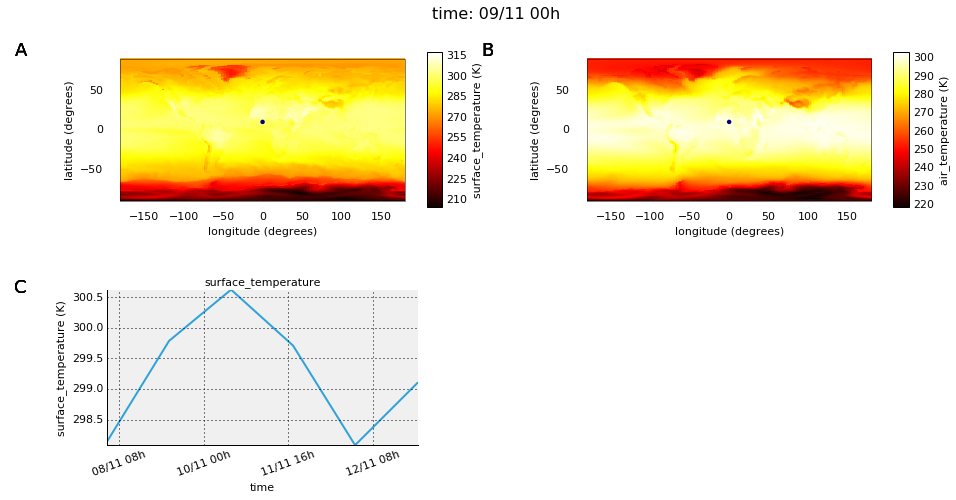
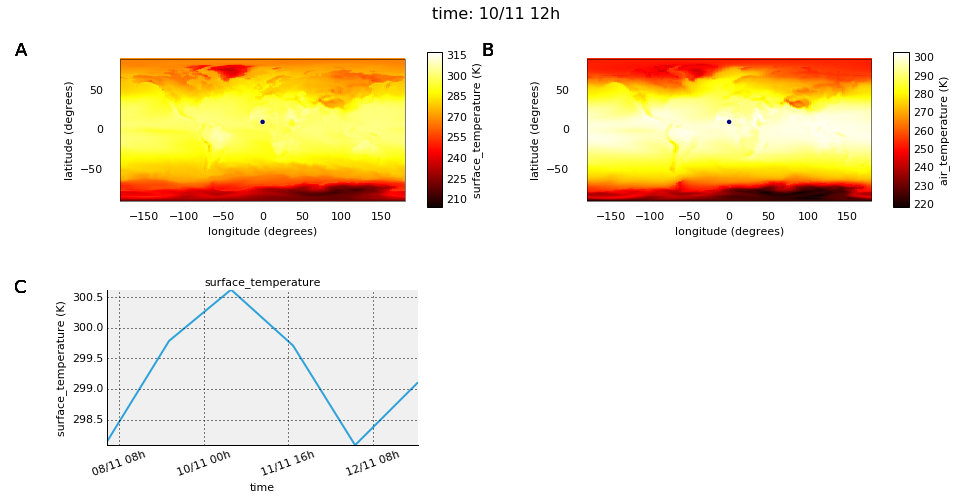
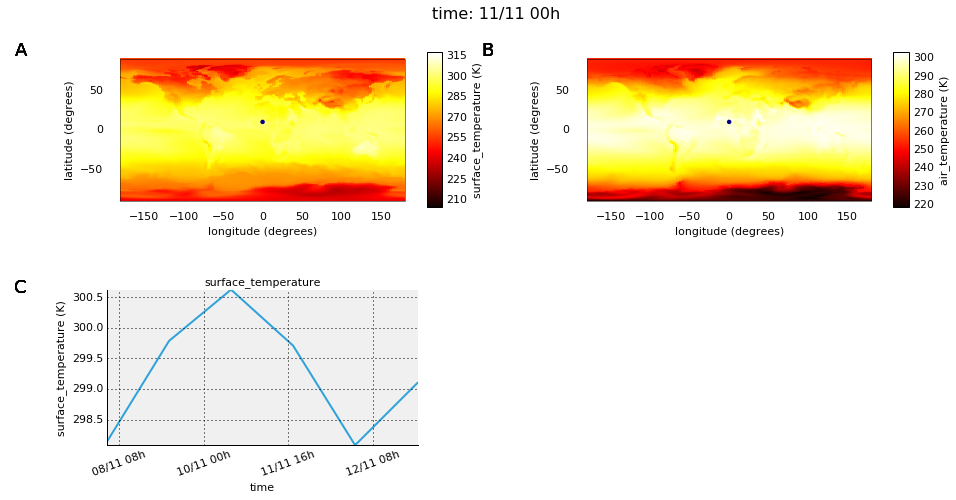
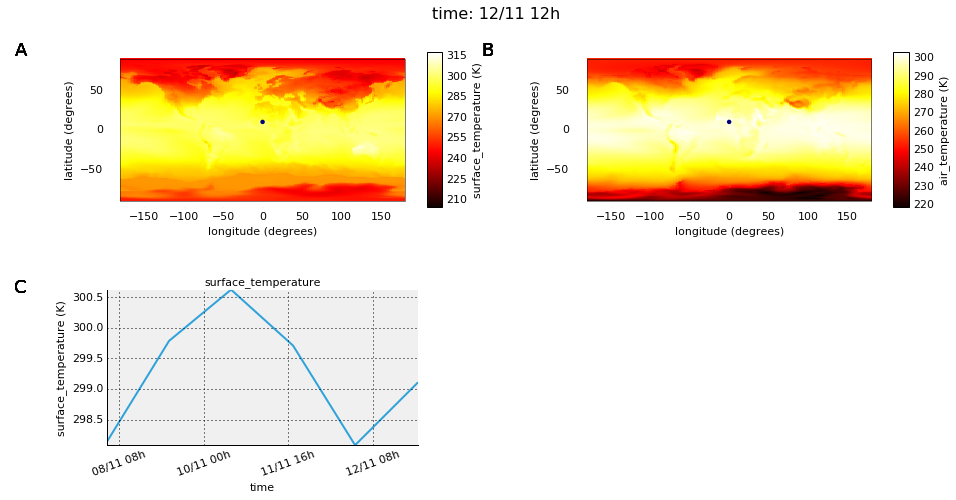
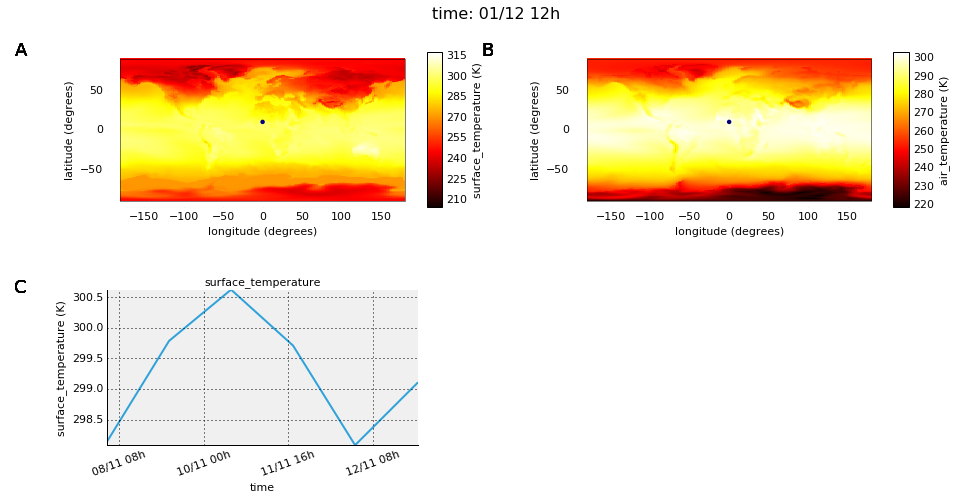

In [12]:
%%opts Layout [fig_inches=(12,7)] Curve [aspect=2 xticks=4 xrotation=20] Points (color=2)
%%opts Image [projection=crs.PlateCarree()]

temp_curve = hv.Curve(surface_temperature.select(longitude=0, latitude=10), kdims=['time'])

temp_maps = [cb.to(gv.Image,['longitude', 'latitude']) * gv.Points([(0,10)]) 
             for cb in [surface_temperature, air_temperature]]

hv.Layout(temp_maps + [temp_curve]).cols(2).display('all')

## Overlaying data and normalization

Let's view the surface temperatures together with the global coastline:

/Users/philippjfr/miniconda/envs/science/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


:HoloMap   [time]
   :Overlay
      .Surface_temperature.I :Image   [longitude,latitude]   (surface_temperature)
      .Feature.I             :Feature   [Longitude,Latitude]
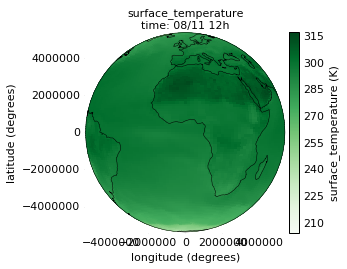
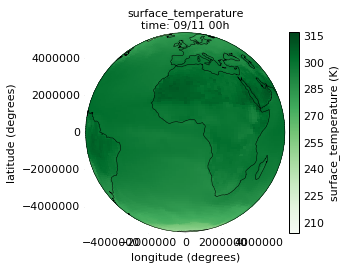
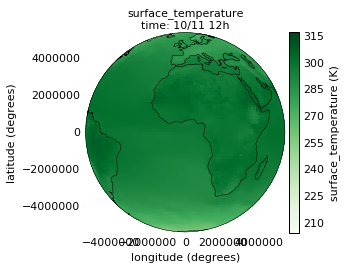
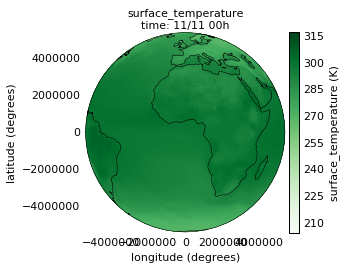
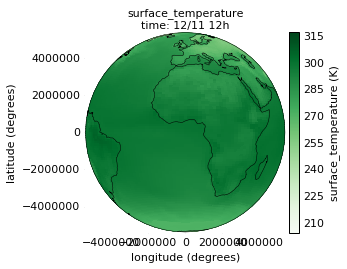
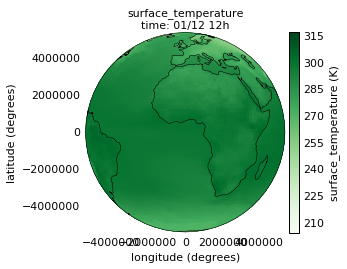

In [13]:
%%opts Image [projection=crs.Geostationary()] (cmap='Greens')
surface_temperature.to.image(['longitude', 'latitude']) * gv.Feature(cf.COASTLINE)

Notice that every frame individually uses the full dynamic range of the Greens color map. This is because normalization is set to ``+framewise`` at the top of the notebook, which means every frame is normalized independently. 

To control normalization, we need to decide on the normalization limits. Let's see the maximum temperature in the cube:

In [14]:
max_surface_temp = surface_temperature.data.data.max()
max_surface_temp

317.33179

:HoloMap   [time]
   :Overlay
      .Surface_temperature.I :Image   [longitude,latitude]   (surface_temperature)
      .Feature.I             :Feature   [Longitude,Latitude]
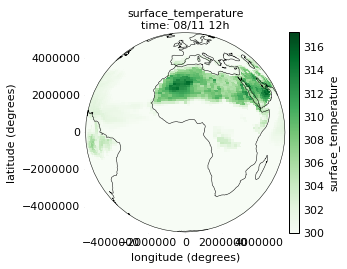
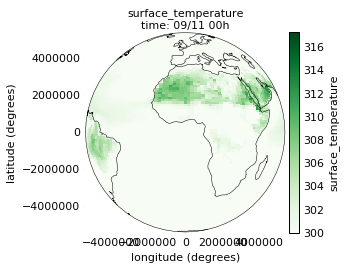
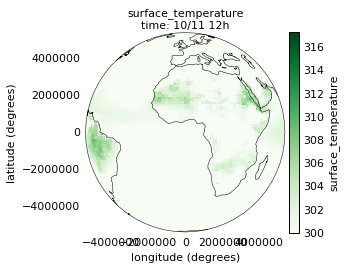
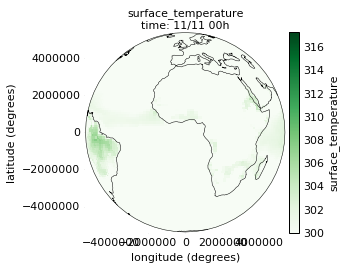
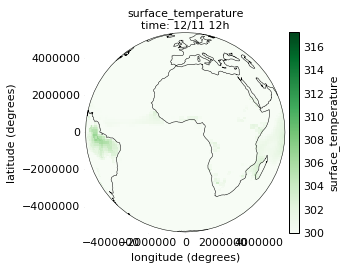
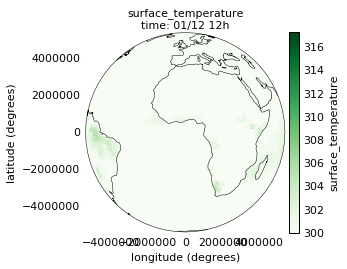

In [15]:
%%opts Image [projection=crs.Geostationary()] (cmap='Greens')
# Declare a humidity dimension with a range from 0 to 0.01
surface_temp_dim = hv.Dimension('surface_temperature', range=(300, max_surface_temp))
# Use it to declare the value dimension of a Dataset
hv.Dataset(surface_temperature, vdims=[surface_temp_dim]).to(gv.Image,['longitude', 'latitude']) * gv.Feature(cf.COASTLINE)

By specifying the normalization range we can reveal different aspects of the data. In the example above we can see a cooling effect over time as the dark green areas close to the top of the normalization range (316K) vanish. Values outside this range are clipped to the ends of the color map.

Lastly, here is a demo of a conversion from ``surface_temperature`` to ``FilledContours``:

:HoloMap   [time]
   :Overlay
      .Surface_temperature.I :FilledContours   [longitude,latitude]   (surface_temperature)
      .Feature.I             :Feature   [Longitude,Latitude]
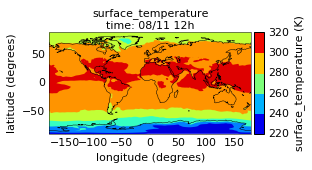
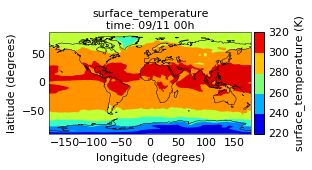
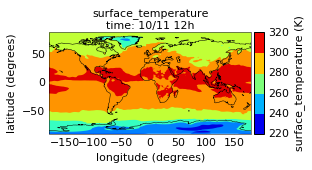
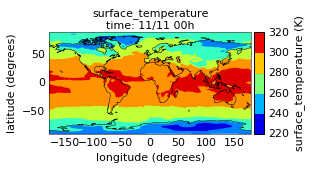
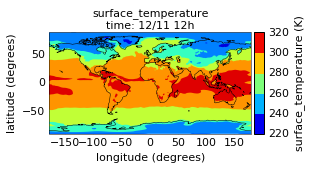
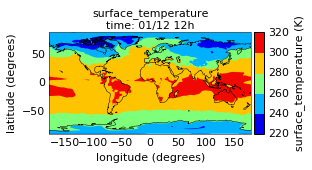

In [16]:
surface_temperature.to(gv.FilledContours,['longitude', 'latitude']) * gv.Feature(cf.COASTLINE)